In [1]:
# NOTEBOOK TO DEVELOP AND TEST THE NEW SPATIAL INFORMATION METHODS
import sys, os
sys.path.insert(0, os.getcwd())
sys.path.insert(0, os.path.dirname(os.getcwd()))
sys.path.insert(0,os.path.join(os.path.dirname(os.getcwd()), "testing"))
from testing.isi_corr import *

In [7]:
# First, look at pairwise distances between matches that we currently get out.
test_data_root = os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), "R_DATA_UnitMatch")
mt_path = os.path.join(test_data_root, "AL031", "19011116684", "1", "new_matchtable.csv")
mt = pd.read_csv(mt_path)

def get_matches(mt:pd.DataFrame, rec1:int, rec2:int, dnn_metric:str="DNNSim", 
                 um_metric:str="MatchProb", dist_thresh=20, mt_path=None):
    mt = mt.loc[(mt["RecSes1"].isin([rec1,rec2])) & (mt["RecSes2"].isin([rec1,rec2])),:]
    if len(mt) < 40:
        return None, None, None, None
    try:
        thresh = dnn_dist.get_threshold(mt, metric=dnn_metric, vis=False)
    except:
        return None, None, None, None
    if um_metric=="MatchProb":
        thresh_um=0.5
    else:
        if um_metric=="ScoreExclCentroid":
            col = mt.loc[:, "WavformSim":"LocTrajectorySim"]
            mt[um_metric] = col.mean(axis=1)
        thresh_um = dnn_dist.get_threshold(mt, metric=um_metric, vis=False)
    within = mt.loc[(mt["RecSes1"]==mt["RecSes2"]), [dnn_metric, "ISICorr", "ID1", "ID2", um_metric, "RecSes1", "RecSes2"]]
    across = mt.loc[(mt["RecSes1"]!=mt["RecSes2"]), [dnn_metric, "ISICorr", um_metric, "RecSes1", "RecSes2", "ID1", "ID2"]]

    # Correct for different median similarities between within- and across-day sets.
    diff = np.median(within[dnn_metric]) - np.median(across[dnn_metric])
    thresh = thresh - diff
    diff_um = np.median(within[um_metric]) - np.median(across[um_metric])
    thresh_um = thresh_um - diff_um

    # Apply thresholds to generate matches for DNN and UnitMatch respectively
    matches_across = across.loc[mt[dnn_metric]>=thresh, ["ISICorr", "RecSes1", "RecSes2", "ID1", "ID2", dnn_metric]]
    um_matches = across.loc[mt[um_metric]>=thresh_um, ["ISICorr", "RecSes1", "RecSes2", "ID1", "ID2", um_metric]]

    return matches_across, um_matches, within, thresh, thresh_um

matches_across, um_matches, within, thresh, thresh_um = get_matches(mt, 1,2)

In [12]:
filtered = spatial_filter(mt_path, matches_across, 20, True, False)

(array([166.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  17.]),
 array([ 0. ,  1.5,  3. ,  4.5,  6. ,  7.5,  9. , 10.5, 12. , 13.5, 15. ]),
 <BarContainer object of 10 artists>)

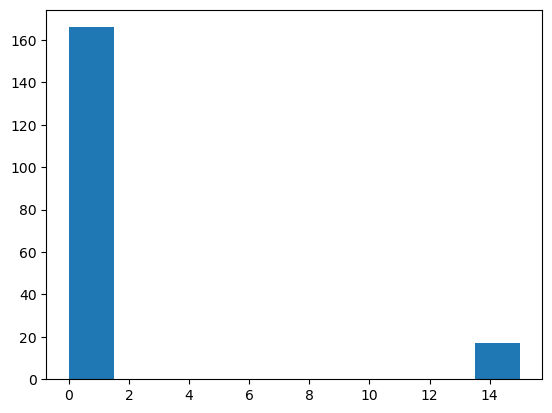

In [16]:
plt.hist(filtered["dist"])
# After filtering, we have 183 matches, of which 166 have dc_dist=0, and 17 have dc_dist=15